# Deep Leakage from Gradients 

## Introduction

This notebook aims to implement a simple algorithm introduced by [Deep Leakage from Gradients](https://arxiv.org/abs/1906.08935) that demonstrates how an image can be reconstructed based on the gradients of the neural network that is being used. This poses a big privacy threat for the field of federated learning which relies on the idea that sharing gradients would not leak any data and preserve the private data of the clients participating. 

## Notebook outline
1. Method
2. Code and Result
3. Conclusion

### Method

The algorithm is from the paper on Deep Leakage from Gradients. They demonstrated that it is possible to reconstruct original training data, the inputs and their labels, by exploiting the mathematical relationship between gradients and data. Specifically, given a model and its shared gradients with respect to a single training sample, the attacker initializes dummy data and iteratively updates it via gradient descent to minimize the difference between the dummy gradients and the observed ones. Through this optimization process, the dummy data converges to the original training example, revealing that sharing raw gradients can result in significant privacy leakage.

The problem consists of minimizing the following loss function:
$$
\min_{x', y'} \left\| \nabla_w L(x', y'; w) - \nabla_w L(x, y; w) \right\|^2
$$

<p align="center">
    <img src="images/image.png" width="500"/>
</p>

2.6.0 0.21.0
Running on cpu


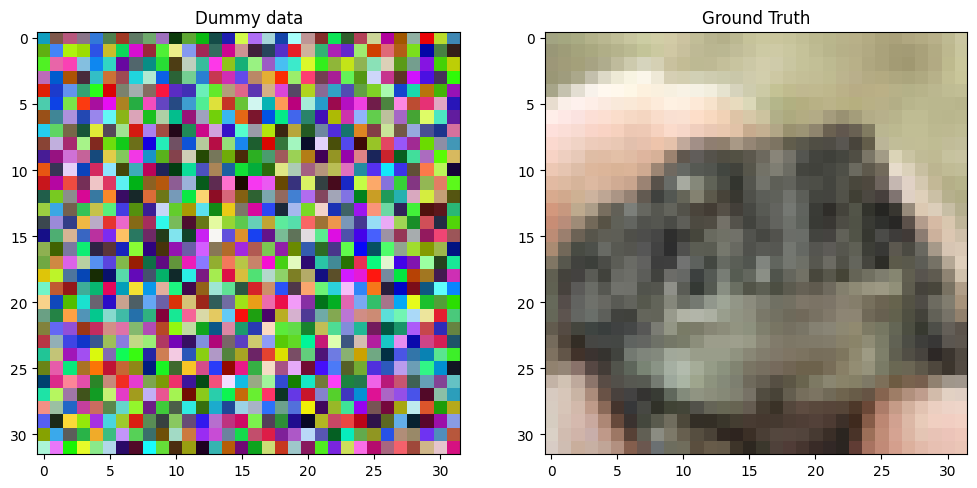

0 39.7208
10 0.7578
20 0.0666
30 0.0117
40 0.0028
50 0.0009
60 0.0003
70 0.0001
80 0.0001
90 0.0000
100 0.0000
110 0.0000
120 0.0000
130 0.0000
140 0.0000
150 0.0000
160 0.0000
170 0.0000
180 0.0000
190 0.0000


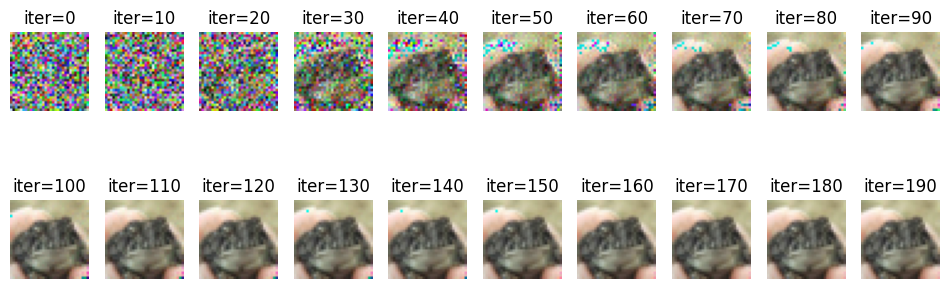

In [10]:
# Import libraries
import argparse
import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms

print(torch.__version__, torchvision.__version__)


# Helper functions
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)


# parser = argparse.ArgumentParser(description='Deep Leakage from Gradients.')
# parser.add_argument('--index', type=int, default="25",
#                     help='the index for leaking images on CIFAR.')
# parser.add_argument('--image', type=str,default="",
#                     help='the path to customized image.')
# args = parser.parse_args()

image = ""

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# Load CIFAR-10 dataset
dst = datasets.CIFAR10("~/.torch", download=True)
n_classes = 10
tp = transforms.ToTensor()
tt = transforms.ToPILImage()

img_index = 25
gt_data = tp(dst[img_index][0]).to(device)

if len(image) > 1:
    gt_data = Image.open(image)
    gt_data = tp(gt_data).to(device)


gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=n_classes)



from model import CNN, Net

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, n_classes)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


net = LeNet().to(device)

torch.manual_seed(1234)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

# compute original gradient 
pred = net(gt_data)
y = criterion(pred, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

original_dy_dx = list((_.detach().clone() for _ in dy_dx))

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)


fig, axes  = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(tt(dummy_data[0].cpu()))
axes[1].imshow(tt(gt_data[0].cpu()))
axes[0].set_title('Dummy data')
axes[1].set_title('Ground Truth')
plt.show()

optimizer = torch.optim.LBFGS([dummy_data, dummy_label])


history = []
for iters in range(200):
    def closure():
        optimizer.zero_grad()

        dummy_pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))
    

plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(history[i])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')

plt.show()

## Conclusion

While the results are very promising this method relies on some big assumptions, such as a batch size of 1. As the batch size increases, the time for reconstruction increase, and at a batch size of 8 it becomes impossible. Furthermore, it is assumed that the architecture of the model is known. However, this still demonstrates that there is a real concern for reconstruction of data through the use of shared gradients. An improved version of the DLG algorithm was also introduced which showed that the label could be determined analytically and this would accelerate the convergence of the optimization. 